# **Desenho do experimento**

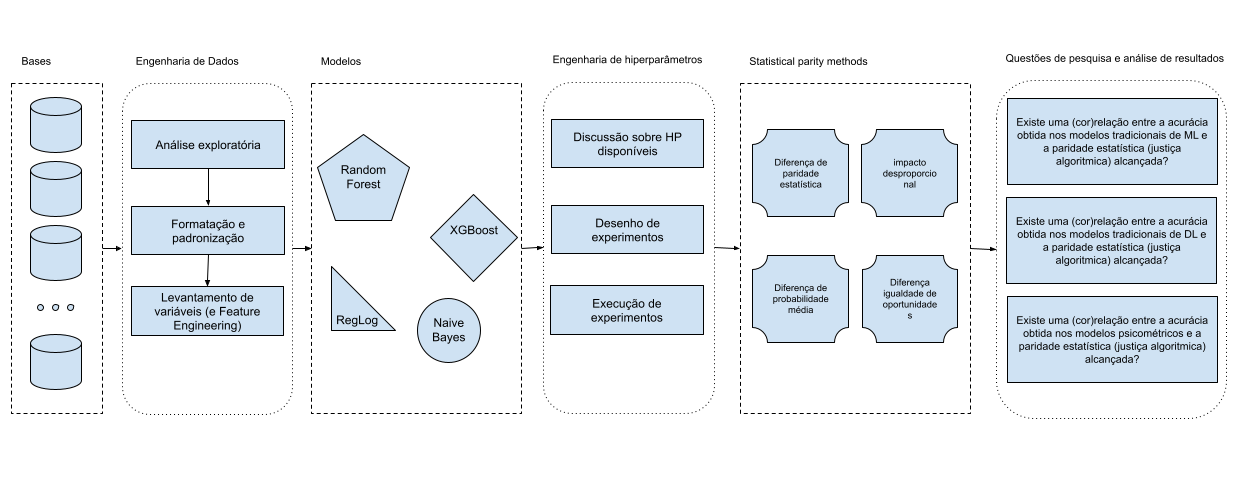

# Importações e instalações de biblioteca

In [1]:
!pip install 'aif360[Reductions,inFairness]'
!pip install xlrd


Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [2]:
from BibliotecasEFuncoes import * 

2024-05-21 14:22:37.137485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 14:22:39.885654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/tuao/anaconda3/envs/aif360/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


# Lendo e preprocessando a base de dados

In [3]:
base = 'german'
german = pd.read_csv('Datasets/german(mais_novo).csv', sep='\s+')
german.head(3)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1


**Recodificando classes (0 e 1)**

De: [1 = Good, 2 = Bad] ---> Para: [1 = Good, 0 = Bad]

In [4]:
german.loc[german['class'] == 2, 'class'] = 0

In [5]:
german.head(3)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1


**Produzindo categorias para faixa etária**

In [6]:
# # faixas etarias retiradas de: https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/
# german.loc[german['Idade']<=18, 'age_group'] = 'under-18'
# german.loc[german['Idade'].between(18,24), 'age_group'] = 'yadult'
# german.loc[german['Idade'].between(25,40), 'age_group'] = 'adult'
# german.loc[german['Idade'].between(41,56), 'age_group'] = 'madult'
# german.loc[german['Idade'].between(55,75), 'age_group'] = 'oadult'
# german.loc[german['Idade']>76, 'age_group'] = 'elder'
# german.head()

In [7]:
# Tem que ser binário
# faixas etarias retiradas de: https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/
german.loc[german['Idade']<=24, 'faixa_etaria'] = 'jovem'
german.loc[german['Idade']>24, 'faixa_etaria'] = 'adulto'
german.head()

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class,faixa_etaria
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1,adulto
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,0,jovem
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1,adulto
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1,adulto
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,0,adulto


**Produzindo categoria binária de sexo**

In [8]:
  #'EstCivil_Sexo_A91' = Male Single/Divorced/Separated
  #'EstCivil_Sexo_A92' = Female Single/Divorced/Separated
  #'EstCivil_Sexo_A93' = Male Married/Widowed
  #'EstCivil_Sexo_A94' = Female Married/Widowed
german.loc[german['EstCivil_Sexo'].isin(["A91","A93"]), 'Sexo'] = 'male'
german.loc[german['EstCivil_Sexo'].isin(["A92","A94"]), 'Sexo'] = 'female'
german.head(3)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class,faixa_etaria,Sexo
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1,adulto,male
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,0,jovem,female
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1,adulto,male


In [9]:
german.dtypes

ContaCorrente               object
DuracaodoCred                int64
HistoricoCred               object
PropositoCred               object
ValorCred                    int64
Poup_Titulos                object
Tmp_Emprego_Atual           object
TxParc_PorcRendaDisp         int64
EstCivil_Sexo               object
OutrosDevedores_Fiadores    object
ResidAtualDesde              int64
Propriedade                 object
Idade                        int64
OutrosPlanosParc            object
Moradia                     object
NumCredExistentesNoBanco     int64
Emprego                     object
NumPessoasRespManut          int64
Telefone                    object
TrabEstrangeiro             object
class                        int64
faixa_etaria                object
Sexo                        object
dtype: object

In [10]:
# separando rótulo (variável dependente y)
german_y = german['class']

## Codificando categóricas

In [11]:
categorical_features = [i for i in german.columns if german.dtypes[i] in ['object', 'category']]
categorical_features

['ContaCorrente',
 'HistoricoCred',
 'PropositoCred',
 'Poup_Titulos',
 'Tmp_Emprego_Atual',
 'EstCivil_Sexo',
 'OutrosDevedores_Fiadores',
 'Propriedade',
 'OutrosPlanosParc',
 'Moradia',
 'Emprego',
 'Telefone',
 'TrabEstrangeiro',
 'faixa_etaria',
 'Sexo']

In [12]:
categorical_names = {}
encoders = {}

for feature in categorical_features:
  le = LabelEncoder()
  le.fit(german[feature])

  german[feature] = le.transform(german[feature])

  categorical_names[feature] = le.classes_
  encoders[feature] = le

In [13]:
german = german.astype(int)
german.dtypes
# todos devem estar codificados em int64

ContaCorrente               int64
DuracaodoCred               int64
HistoricoCred               int64
PropositoCred               int64
ValorCred                   int64
Poup_Titulos                int64
Tmp_Emprego_Atual           int64
TxParc_PorcRendaDisp        int64
EstCivil_Sexo               int64
OutrosDevedores_Fiadores    int64
ResidAtualDesde             int64
Propriedade                 int64
Idade                       int64
OutrosPlanosParc            int64
Moradia                     int64
NumCredExistentesNoBanco    int64
Emprego                     int64
NumPessoasRespManut         int64
Telefone                    int64
TrabEstrangeiro             int64
class                       int64
faixa_etaria                int64
Sexo                        int64
dtype: object

In [14]:
german.head(5)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class,faixa_etaria,Sexo
0,0,6,4,4,1169,4,4,4,2,0,4,0,67,2,1,2,2,1,1,0,1,0,1
1,1,48,2,4,5951,0,2,2,1,0,2,0,22,2,1,1,2,1,0,0,0,1,0
2,3,12,4,7,2096,0,3,2,2,0,3,0,49,2,1,1,1,2,0,0,1,0,1
3,0,42,2,3,7882,0,3,2,2,2,4,1,45,2,2,1,2,2,0,0,1,0,1
4,0,24,3,0,4870,0,2,3,2,0,4,3,53,2,2,2,2,2,0,0,0,0,1


In [15]:
# Definições sobre os dados para avaliação de justiça
label_name ='class'
protected_attribute_names = ['Sexo', 'faixa_etaria']
favorable_classes = np.where(german['class'] == 1)[0]

# Definição de categoria privilegiada para cada atributo protegido
  #'EstCivil_Sexo_A91' = Male Single/Divorced/Separated
  #'EstCivil_Sexo_A92' = Female Single/Divorced/Separated
  #'EstCivil_Sexo_A93' = Male Married/Widowed
  #'EstCivil_Sexo_A94' = Female Married/Widowed

# Definindo as populações privilegiadas e não-privilegiadas
# Sexo
## Recuperando o indice
privileged_sex   = np.where(categorical_names['Sexo'] == 'male')[0]
unprivileged_sex = np.where(categorical_names['Sexo'] == 'female')[0]
## Estabelecendo formato, seguindo o formato da documentacao das classes ClassificationMetric and BinaryLabelDatasetMetric
privileged_groups   = [{'Sexo' : privileged_sex}]
unprivileged_groups = [{'Sexo' : unprivileged_sex}]

# Idade
## Recuperando o indice
privileged_faixa_etaria   = np.where(categorical_names['faixa_etaria'] == 'adulto')[0]
unprivileged_faixa_etaria = np.where(categorical_names['faixa_etaria'] == 'jovem')[0]
## Estabelecendo formato, seguindo o formato da documentacao das classes ClassificationMetric and BinaryLabelDatasetMetric
privileged_groups_fe   = [{'faixa_etaria' : privileged_faixa_etaria}]
unprivileged_groups_fe = [{'faixa_etaria' : unprivileged_faixa_etaria}]


# Dados privilegiados
privileged_classes = [privileged_sex, privileged_faixa_etaria]

In [16]:
favorable_classes

array([  0,   2,   3,   5,   6,   7,   8,  12,  14,  16,  17,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  30,  31,  32,  33,  34,
        36,  38,  39,  40,  41,  42,  43,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  55,  57,  58,  60,  61,  64,  65,  66,  67,  69,
        70,  71,  72,  73,  75,  77,  78,  79,  81,  82,  83,  84,  85,
        86,  88,  90,  91,  93,  94,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 107, 108, 109, 110, 111, 112, 114, 115, 117, 119, 121,
       122, 123, 125, 126, 128, 130, 132, 133, 134, 135, 136, 138, 139,
       140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168,
       171, 173, 176, 177, 178, 179, 183, 185, 187, 189, 193, 196, 198,
       200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 229, 231, 232,
       233, 234, 238, 239, 241, 243, 244, 245, 246, 247, 248, 25

In [17]:
favorable_classes[0]

0

In [18]:
len(german)

1000

# Preparando experimentos

In [20]:
list_gbt_params, list_rf_params = preparando_experimentos()
print(list_gbt_params)

Total de 5 conjuntos de parâmetros.
Total de 2 conjuntos de parâmetros.
[{'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2024}, {'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.2, 'max_depth': 2, 'random_state': 2024}, {'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.3, 'max_depth': 2, 'random_state': 2024}, {'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.4, 'max_depth': 2, 'random_state': 2024}, {'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.5, 'max_depth': 2, 'random_state': 2024}]


# Toda a base

### GBT

In [29]:
exp1_all_gbt = justica_exps(base, 'toda-a-base', german, list_gbt_params, 'gbt', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes, privileged_groups, unprivileged_groups, privileged_groups_fe, unprivileged_groups_fe)

<class 'dict'>
{'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2024}
0.75 de acuracia com desvio padrão de 0.05
0.66 de f1 com desvio padrão de 0.08
0.78 de precisão com desvio padrão de 0.04
0.78 de score no teste
STATISTICAL PARITY DIFFERENCE
Atributo sexo: -0.06028708133971292
Atributo faixa_etaria: -0.18561671353957412

DISPARATE IMPACT
Atributo sexo: 0.7236842105263158
Atributo faixa_etaria: 0.457428068115091
 
AVERAGE ODDS DIFFERENCE
Atributo sexo: -0.0874391507615192
Atributo faixa_etaria: -0.17535014005602242
 
EQUAL OPPORTUNITY DIFFERENCE
Atributo sexo: -0.14528508771929827
Atributo faixa_etaria: -0.24285714285714288
{'index': 0, 'base': 'german', 'attr_set': 'toda-a-base', 'modelo': 'gbt', 'param_set': "{'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2024}", '10fold-acuracia': 0.7471428571428571, '10fold-f1': 0.6554539002450709, '10fold-precisao': 0.7773136611432564, 'tes

In [30]:
csv_result = pd.DataFrame(exp1_all_gbt, index=[3])
csv_result.to_csv('Resultados/03-German_GBT.csv')
print(csv_result)

   index    base     attr_set modelo                                          param_set  10fold-acuracia  10fold-f1  10fold-precisao  test-score  spd_sexo  spd_faixa_etaria   di_sexo  di_faixa_etaria  aod_sexo  aod_faixa_etaria  eod_sexo  eod_faixa_etaria
3      4  german  toda-a-base    gbt  {'n_estimators': 100, 'min_samples_split': 50,...         0.764286   0.703784         0.816278        0.73 -0.076966         -0.206349  0.733919         0.504762 -0.055743         -0.157848    -0.057         -0.174242


### RF

In [24]:
exp2_all_rf = justica_exps(base, 'toda-a-base', german, list_rf_params, 'rf', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes, unprivileged_groups, privileged_groups, unprivileged_groups_fe, privileged_groups_fe)

<class 'dict'>
{'n_estimators': 100, 'min_samples_split': 50, 'criterion': 'gini', 'max_depth': 2, 'random_state': 2024}
0.70 de acuracia com desvio padrão de 0.01
0.42 de f1 com desvio padrão de 0.02
0.70 de precisão com desvio padrão de 0.01
0.71 de score no teste
STATISTICAL PARITY DIFFERENCE
Atributo sexo: 0.0
Atributo faixa_etaria: 0.0

DISPARATE IMPACT
Atributo sexo: nan
Atributo faixa_etaria: nan
 
AVERAGE ODDS DIFFERENCE
Atributo sexo: 0.0
Atributo faixa_etaria: 0.0
 
EQUAL OPPORTUNITY DIFFERENCE
Atributo sexo: 0.0
Atributo faixa_etaria: 0.0
{'index': 0, 'base': 'german', 'attr_set': 'toda-a-base', 'modelo': 'rf', 'param_set': "{'n_estimators': 100, 'min_samples_split': 50, 'criterion': 'gini', 'max_depth': 2, 'random_state': 2024}", '10fold-acuracia': 0.7, '10fold-f1': 0.42055651228133784, '10fold-precisao': 0.6991718426501036, 'test-score': 0.7066666666666667, 'spd_sexo': 0.0, 'spd_faixa_etaria': 0.0, 'di_sexo': nan, 'di_faixa_etaria': nan, 'aod_sexo': 0.0, 'aod_faixa_etaria'

/home/tuao/anaconda3/envs/aif360/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


0.68 de acuracia com desvio padrão de 0.02
0.42 de f1 com desvio padrão de 0.02
0.69 de precisão com desvio padrão de 0.01
0.74 de score no teste
STATISTICAL PARITY DIFFERENCE
Atributo sexo: -0.005494505494505495
Atributo faixa_etaria: -0.003861003861003861

DISPARATE IMPACT
Atributo sexo: 0.0
Atributo faixa_etaria: 0.0
 
AVERAGE ODDS DIFFERENCE
Atributo sexo: -0.011111111111111112
Atributo faixa_etaria: -0.008064516129032258
 
EQUAL OPPORTUNITY DIFFERENCE
Atributo sexo: -0.022222222222222223
Atributo faixa_etaria: -0.016129032258064516
{'index': 1, 'base': 'german', 'attr_set': 'toda-a-base', 'modelo': 'rf', 'param_set': "{'n_estimators': 100, 'min_samples_split': 50, 'criterion': 'entropy', 'max_depth': 2, 'random_state': 2024}", '10fold-acuracia': 0.6828571428571429, '10fold-f1': 0.4180951301094118, '10fold-precisao': 0.6853416149068323, 'test-score': 0.74, 'spd_sexo': -0.005494505494505495, 'spd_faixa_etaria': -0.003861003861003861, 'di_sexo': 0.0, 'di_faixa_etaria': 0.0, 'aod_sexo

In [28]:
csv_result2 = pd.DataFrame(exp2_all_rf, index=[8])
csv_result2.to_csv('Resultados/08-German_RF.csv')
print(csv_result2)

   index    base     attr_set modelo                                          param_set  10fold-acuracia  10fold-f1  10fold-precisao  test-score  spd_sexo  spd_faixa_etaria  di_sexo  di_faixa_etaria  aod_sexo  aod_faixa_etaria  eod_sexo  eod_faixa_etaria
8      1  german  toda-a-base     rf  {'n_estimators': 100, 'min_samples_split': 50,...         0.682857   0.418095         0.685342        0.74 -0.005495         -0.003861      0.0              0.0 -0.011111         -0.008065 -0.022222         -0.016129
